In [32]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [41]:
import pandas as pd
data = pd.read_csv("data/DBH_with_properties_DBHbinding.txt")

X = data.drop(columns=["Label","SMILES"])
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

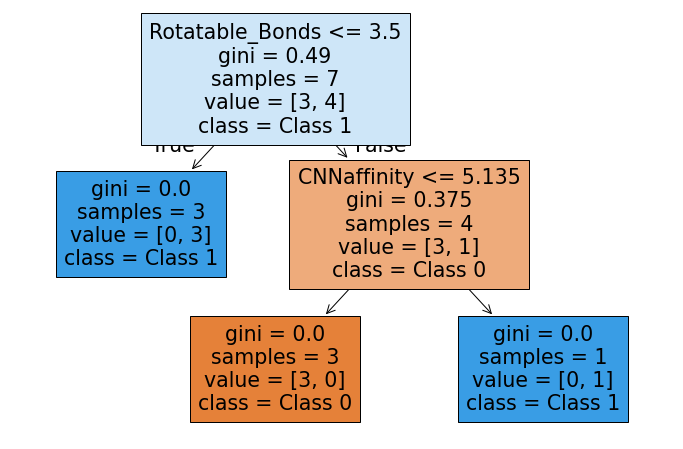

In [42]:
from sklearn.tree import export_text

tree_rules = export_text(clf, feature_names=list(X.columns))

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=["Class 0", "Class 1"], filled=True)
plt.show()

In [43]:
def extract_ranges(tree, feature_names):
    """
    Extract feature ranges from a decision tree classifier.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!" for i in tree_.feature
    ]
    ranges = {}

    def recurse(node, current_ranges):
        if tree_.feature[node] != -2: 
            name = feature_name[node]
            threshold = tree_.threshold[node]

            left_ranges = current_ranges.copy()
            left_ranges[name] = (left_ranges.get(name, [-float("inf"), float("inf")])[0], threshold)
            recurse(tree_.children_left[node], left_ranges)

            right_ranges = current_ranges.copy()
            right_ranges[name] = (threshold, right_ranges.get(name, [-float("inf"), float("inf")])[1])
            recurse(tree_.children_right[node], right_ranges)
        else:
            class_label = tree_.value[node].argmax()
            if class_label not in ranges:
                ranges[class_label] = []
            ranges[class_label].append(current_ranges)

    recurse(0, {})
    return ranges

def simplify_and_fix_ranges(ranges):
    simplified = {}
    for class_label, class_rules in ranges.items():
        simplified[class_label] = {}
        for feature in class_rules[0]:  
            min_val = float('-inf')
            max_val = float('inf')
            for rule in class_rules:
                if feature in rule:
                    min_val = max(min_val, rule[feature][0]) 
                    max_val = min(max_val, rule[feature][1])
            if min_val > max_val:
                min_val, max_val = max_val, min_val
            simplified[class_label][feature] = (min_val, max_val)
    return simplified

In [44]:
ranges = extract_ranges(clf, list(X.columns))
final_fixed_ranges = simplify_and_fix_ranges(ranges)
for class_label, feature_ranges in final_fixed_ranges.items():
    print(f"Class {class_label}:")
    for feature, value_range in feature_ranges.items():
        print(f"  {feature}: {value_range}")

Class 1:
  Rotatable_Bonds: (3.5, 3.5)
Class 0:
  Rotatable_Bonds: (3.5, inf)
  CNNaffinity: (-inf, 5.135499954223633)


In [45]:
feature_importance = np.array(clf.feature_importances_)
features = np.array(X.columns)
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f"{features[i]}: {feature_importance[i]}")

Rotatable_Bonds: 0.5625
CNNaffinity: 0.4375
Affinity: 0.0
H_Donors: 0.0
H_Acceptors: 0.0
TPSA: 0.0
SAS: 0.0
QED: 0.0
LogP: 0.0
MolWt: 0.0
